# Calculate geostrophic wind speed (UGEO) at pressure levels 925, 850, 700
RUFMOD ONLY

* **Description**: Reads in and creates seasonal and ensemble means and vertically interpolates
* **Input data**: Rufmod output in timeseries format
* **Output data**: Netcdf file with output
* **Creator**: Alice DuVivier
* **Date**: April 2022

The rufmod experiments were performed where the sea ice roughness over Arctic sea ice regions was set to be equal to what it would be over open ocean. This is to better understand ice-atmosphere coupling, processes, and feedbacks.

In [1]:
import xarray as xr
import numpy as np
from datetime import timedelta
import glob

import pop_tools

import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec

import geocat.datafiles as gdf
import geocat.viz.util as gvutil
from geocat.viz import cmaps as gvcmaps
import geocat.comp as gcomp

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress,pearsonr, t
import metpy.calc as mpcalc

import dask
import intake
from distributed import Client
from ncar_jobqueue import NCARCluster

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
# spin up dask cluster

import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=36, # The number of cores you want
    memory='300 GB', # Amount of memory
    processes=9, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=36:mem=300GB', # Specify resources
    project='P93300665', # Input your project ID here
    walltime='00:30:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(jobs=4)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35136 instead
  f"Port {expected} is already in use.\n"


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/35136/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/35136/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.22:46331,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/35136/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Manually set variables

In [4]:
# list the variables to load
var_in_1 = 'Z3'

## Load rufmod experiments

In [5]:
# Load "rufmod" data
#choose cases and data paths
case1 = 'b.e21.BSSP370.f09_g17.rufmod.001'
case2 = 'b.e21.BSSP370.f09_g17.rufmod.002'
case3 = 'b.e21.BSSP370.f09_g17.rufmod.003'
case4 = 'b.e21.BSSP370.f09_g17.rufmod.004'
case5 = 'b.e21.BSSP370.f09_g17.rufmod.005'

# set base directory where all data live
data_dir = '/glade/campaign/cesm/development/pcwg/projects/arctic_cyclones/rufmod_expts/'
# set individual data directories
data_dir1 = data_dir+case1+'/atm/proc/tseries/month_1/'
data_dir2 = data_dir+case2+'/atm/proc/tseries/month_1/'
data_dir3 = data_dir+case3+'/atm/proc/tseries/month_1/'
data_dir4 = data_dir+case4+'/atm/proc/tseries/month_1/'
data_dir5 = data_dir+case5+'/atm/proc/tseries/month_1/'

In [6]:
%%time
#reading in files
print("loading "+var_in_1)   
ds1_1 = []
ds2_1 = []
ds3_1 = []
ds4_1 = []
ds5_1 = []
my_files=sorted(glob.glob(data_dir1+case1+'.cam.h0.'+var_in_1+'.*.nc'))
ds1_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={'time':129}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir2+case2+'.cam.h0.'+var_in_1+'.*.nc'))
ds2_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={'time':129}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir3+case3+'.cam.h0.'+var_in_1+'.*.nc'))
ds3_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={'time':129}, parallel=True, compat='override', coords='minimal')    
my_files=sorted(glob.glob(data_dir4+case4+'.cam.h0.'+var_in_1+'.*.nc'))
ds4_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={'time':129}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir5+case5+'.cam.h0.'+var_in_1+'.*.nc'))
ds5_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={'time':129}, parallel=True, compat='override', coords='minimal')


loading Z3
CPU times: user 854 ms, sys: 311 ms, total: 1.16 s
Wall time: 22.2 s


In [7]:
# concatenate them into a single array
futures_1 = xr.concat([ds1_1,ds2_1,ds3_1,ds4_1,ds5_1],dim='member_id')

In [8]:
futures_1.Z3

<xarray.DataArray 'Z3' (member_id: 5, time: 1032, lev: 32, lat: 192, lon: 288)>
dask.array<concatenate, shape=(5, 1032, 32, 192, 288), dtype=float32, chunksize=(1, 129, 32, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: member_id
Attributes:
    mdims:         1
    units:         m
    long_name:     Geopotential Height (above sea level)
    cell_methods:  time: mean

In [9]:
# set member_id values
futures_1.member_id.values

# assign member_id as coordinate array
futures_1 = futures_1.assign_coords({"member_id": futures_1.member_id.values})

In [10]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
futures_1['time'] = futures_1.time_bnds.load().mean(dim='nbnd').sel(member_id=0)

In [11]:
# get just NH slice
futures_1_masked = futures_1.isel(lat=slice(164,192))

In [12]:
# grab variables of interest
Z_rufmod = futures_1_masked[var_in_1]

## Calculate geopotential height on regular pressure levels

### Get surface pressure

In [13]:
# We will need surface pressure and reference pressure for interpolation

# set a surface reference pressure [Pa]
p0 = 100000 

# set variable name
var_in_3 = 'PS'

In [14]:
# Load surface pressure from rufmod
print("loading rufmod "+var_in_3)   
ds1_3 = []
ds2_3 = []
ds3_3 = []
ds4_3 = []
ds5_3 = []
my_files=sorted(glob.glob(data_dir1+case1+'.cam.h0.'+var_in_3+'.*.nc'))
ds1_3=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir2+case2+'.cam.h0.'+var_in_3+'.*.nc'))
ds2_3=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir3+case3+'.cam.h0.'+var_in_3+'.*.nc'))
ds3_3=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')    
my_files=sorted(glob.glob(data_dir4+case4+'.cam.h0.'+var_in_3+'.*.nc'))
ds4_3=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir5+case5+'.cam.h0.'+var_in_3+'.*.nc'))
ds5_3=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')

loading rufmod PS


In [15]:
# combine the datasets
futures_3 = xr.concat([ds1_3,ds2_3,ds3_3,ds4_3,ds5_3],dim='member_id')

# set member_id values
futures_3.member_id.values

# assign member_id as coordinate array
futures_3.assign_coords({"member_id": futures_3.member_id.values})

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, member_id: 5, time: 1032, nbnd: 2, lon: 288, lev: 32, ilev: 33)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id     (member_id) int64 0 1 2 3 4
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (member_id, time, zlon, nbnd) float64 dask.array<chunksize=(1, 600, 1, 2), meta=np.ndarray>
    gw            (member_id, time, lat) float64 dask.array<chunksize=(1, 600, 192), meta=np.ndarray>
    hyam          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    hybm          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    P0            (member_id, time) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyai          (member_id, time, ilev) float64 dask.array<chunksize=(1, 600, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f11vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f12vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    sol_tsi       (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    nsteph        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    PS            (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSSP370.f09_g17.rufmod.001
    logname:           duvivier
    host:              cheyenne3
    initial_file:      b.e21.BHIST.f09_g17.CMIP6-historical.rufmod.cam.i.2015...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [16]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
futures_3['time'] = futures_3.time_bnds.load().mean(dim='nbnd').sel(member_id=0)

# get just NH slice
futures_3_masked = futures_3.isel(lat=slice(164,192))

# grab variable of interest
PS_rufmod = futures_3_masked[var_in_3]

### Load the vertical parameters

In [17]:
# grab parameters for interpolation
hyam_rufmod = futures_1_masked["hyam"]
hybm_rufmod = futures_1_masked["hybm"]

### Interpolate to new pressure levels from hybrid levels

In [18]:
# Specify output pressure levels
new_levels = np.array([925, 850, 700, 500])  # in millibars
new_levels = new_levels * 100  # convert to Pascals

In [19]:
%%time
Z_rufmod_interp = gcomp.interp_hybrid_to_pressure(Z_rufmod,
                                                   PS_rufmod,
                                                   hyam_rufmod, hybm_rufmod, p0 = p0,
                                                   new_levels=new_levels,
                                                   method='linear')

CPU times: user 14.8 ms, sys: 98 µs, total: 14.9 ms
Wall time: 14.9 ms


In [20]:
Z_rufmod_interp

<xarray.DataArray 'Z3' (member_id: 5, time: 1032, plev: 4, lat: 28, lon: 288)>
dask.array<_vertical_remap, shape=(5, 1032, 4, 28, 288), dtype=float32, chunksize=(1, 129, 4, 28, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 64.55 65.5 66.44 67.38 ... 87.17 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * plev       (plev) int64 92500 85000 70000 50000
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) int64 0 1 2 3 4
Attributes:
    mdims:         1
    units:         m
    long_name:     Geopotential Height (above sea level)
    cell_methods:  time: mean

### Actually load data

In [22]:
Z_rufmod_interp.load()

<xarray.DataArray 'Z3' (member_id: 5, time: 1032, plev: 4, lat: 28, lon: 288)>
array([[[[[ 534.3750879 ,  536.85198726,  539.99934974, ...,
            531.30756625,  532.02469691,  532.79177641],
          [ 530.46886891,  532.23942756,  534.6071675 , ...,
            528.01122511,  528.6434975 ,  529.48875097],
          [ 528.0084335 ,  528.87610869,  530.5599083 , ...,
            526.81864587,  526.98666723,  527.52720764],
          ...,
          [ 567.98900544,  567.53345773,  567.07049358, ...,
            569.33844496,  568.88524152,  568.43709446],
          [ 568.19097213,  568.00777705,  567.82334718, ...,
            568.72627859,  568.54629501,  568.36876716],
          [ 570.00640168,  570.00638586,  570.00638586, ...,
            570.00643108,  570.00643108,  570.00640168]],

         [[1204.19376197, 1206.75029333, 1210.05850336, ...,
           1200.20214251, 1201.27236383, 1202.38698   ],
          [1199.10561405, 1201.18241366, 1203.73500396, ...,
           1195.29800992, 1196.42028567, 1197.66848274],
          [1195.29409987, 1196.62509679, 1198.55154916, ...,
           1192.33786414, 1193.20117895, 1194.29086136],
...
          [2783.80002198, 2783.93219359, 2784.06211619, ...,
           2783.38983851, 2783.52941322, 2783.67808634],
          [2783.24572512, 2783.30919802, 2783.36784456, ...,
           2783.06647238, 2783.12403045, 2783.1856135 ],
          [2782.6649636 , 2782.66519559, 2782.66519559, ...,
           2782.66519559, 2782.66519559, 2782.66519559]],

         [[5432.89594846, 5433.20124831, 5433.1274394 , ...,
           5430.18920252, 5431.36682822, 5432.26793674],
          [5422.60701854, 5423.4937515 , 5424.07237613, ...,
           5418.15780891, 5419.83673353, 5421.31497397],
          [5412.64336032, 5413.98941603, 5415.09956459, ...,
           5407.09409388, 5409.09712562, 5410.97080241],
          ...,
          [5219.14195715, 5219.35978848, 5219.57474558, ...,
           5218.48343893, 5218.70697913, 5218.93556564],
          [5214.17729804, 5214.28771811, 5214.38448308, ...,
           5213.84300605, 5213.95670094, 5214.06917291],
          [5210.17906222, 5210.17937818, 5210.17937818, ...,
           5210.17937818, 5210.17937818, 5210.17937818]]]]])
Coordinates:
  * lat        (lat) float64 64.55 65.5 66.44 67.38 ... 87.17 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * plev       (plev) int64 92500 85000 70000 50000
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) int64 0 1 2 3 4
Attributes:
    mdims:         1
    units:         m
    long_name:     Geopotential Height (above sea level)
    cell_methods:  time: mean

# Calculate geostrophic wind at pressure levels

In [23]:
ug_smooth,vg_smooth = mpcalc.geostrophic_wind(Z_rufmod_interp)

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/pint/quantity.py:1309: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


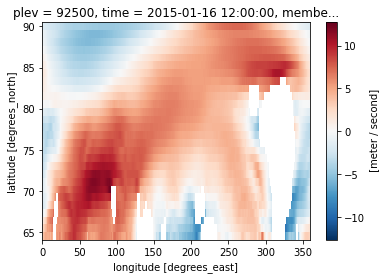

In [25]:
ug_smooth.isel(member_id=0,time=0,plev=0).plot()

In [29]:
spd_smooth = xr.ufuncs.sqrt(ug_smooth**2 + vg_smooth**2)

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  """Entry point for launching an IPython kernel.
/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/dataarray.py:3066: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))


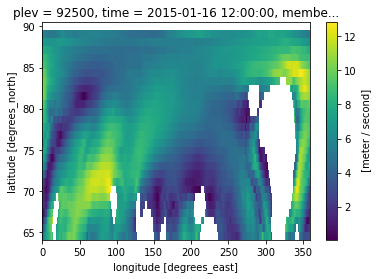

In [30]:
spd_smooth.isel(member_id=0,time=0,plev=0).plot()

# Calculate Seasonal Means

In [31]:
season_names = ['OND','JFM', 'AMJ', 'JAS']

In [32]:
# find total years
xarr_rufmod = spd_smooth.coords['time.year'][(spd_smooth.coords['time.month']==1)]

In [33]:
# Loop through seasons - rufmod

# make numpy array to fill and specify dimensions we want
seas_array_rufmod_1 = np.zeros([len(season_names),len(xarr_rufmod),len(spd_smooth.member_id),len(spd_smooth.plev),len(spd_smooth.lat),len(spd_smooth.lon)])

for s_count, ss in enumerate(season_names):
    print(ss)
    ### Z PLEV
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp1 = spd_smooth.isel(time=spd_smooth.time.dt.month.isin([1,2,3]))
    if ss == 'AMJ':
        temp1 = spd_smooth.isel(time=spd_smooth.time.dt.month.isin([4,5,6]))
    if ss == 'JAS':
        temp1 = spd_smooth.isel(time=spd_smooth.time.dt.month.isin([7,8,9]))
    if ss == 'OND':
        temp1 = spd_smooth.isel(time=spd_smooth.time.dt.month.isin([10,11,12]))
    # now loop through years to get the seasonal average by year for each ensemble member
    for y_count, yy in enumerate(xarr_rufmod):
        # select only the indexes for this year
        temp1a = temp1.isel(time=temp1.time.dt.year.isin([yy])).mean(dim='time')
        seas_array_rufmod_1[s_count,y_count,:,:,:,:] = temp1a 
        

OND
JFM
AMJ
JAS


In [34]:
print(seas_array_rufmod_1.shape)

(4, 86, 5, 4, 28, 288)


In [37]:
# convert the numpy array to a xarray for easier plotting
spd_seas_rufmod = xr.DataArray(seas_array_rufmod_1,dims=('season','time','member_id','plev','lat','lon'))

In [38]:
# set coordinate arrays
spd_seas_rufmod['season'] = season_names
spd_seas_rufmod['time'] = xarr_rufmod
spd_seas_rufmod['member_id'] = Z_rufmod_interp['member_id']
spd_seas_rufmod['plev'] = Z_rufmod_interp['plev'].values
spd_seas_rufmod['lat'] = Z_rufmod_interp['lat'].values
spd_seas_rufmod['lon'] = Z_rufmod_interp['lon'].values

## Write out files

In [ ]:
# quick and dirty way to save a file!

# save rufmod expt, rename the variable so it makes sense
#fout = 'rufmod_vertical_seas_ens_mean_WS'
#
#WS_seas_ens_mean_rufmod.to_dataset(name='vert_ws').to_netcdf(fout+'.nc')

### Z @ PLEVS

In [39]:
#set info to write out
out_tag = 'UGEO'
units = 'm/s'
longname = 'geostrophic wind speed at given plevels'

fout = 'rufmod_seas_'+out_tag

In [41]:
ds_to_save = spd_seas_rufmod

In [42]:
# check how big this will be to write out in GB
ds_to_save.nbytes/(1024**3)

0.413360595703125

In [43]:
# assign some attributes
refdata = {'Author': 'Alice DuVivier', 'units':units, 'longname':longname}

ds_to_save.attrs = refdata

In [44]:
# check data
ds_to_save


<xarray.DataArray (season: 4, time: 86, member_id: 5, plev: 4, lat: 28, lon: 288)>
array([[[[[[ 5.09698461,  5.12114114,  5.15699885, ...,  5.50613491,
             5.2526626 ,  5.01086578],
           [ 5.30297482,  5.27950882,  5.23625817, ...,  5.62270388,
             5.48499824,  5.33127242],
           [ 5.60880279,  5.48402336,  5.34089334, ...,  5.60419159,
             5.53077034,  5.50391877],
           ...,
           [ 2.43305493,  2.42627568,  2.40578892, ...,  2.37618934,
             2.40626555,  2.41768593],
           [ 2.77140831,  2.84494191,  2.89623618, ...,  2.67423134,
             2.71810297,  2.76338728],
           [        nan,         nan,         nan, ...,         nan,
                    nan,         nan]],

          [[ 5.66484647,  5.79981778,  6.06619701, ...,  5.90757034,
             5.71709357,  5.54288709],
           [ 5.56304984,  5.52525442,  5.50879846, ...,  5.75535044,
             5.6287005 ,  5.49878363],
           [ 5.60300785,  5.57841146,  5.53114788, ...,  5.54049748,
             5.5027562 ,  5.50562234],
...
           [ 3.81169236,  3.81715316,  3.82929832, ...,  3.76452112,
             3.80539133,  3.85665375],
           [ 4.01367894,  3.98653962,  3.99365302, ...,  3.90054561,
             3.9263744 ,  3.92899077],
           [        nan,         nan,         nan, ...,         nan,
                    nan,         nan]],

          [[11.09886432, 11.0532198 , 10.95523629, ..., 11.26223058,
            11.19744528, 11.10359248],
           [10.15255252, 10.06329571,  9.98374823, ..., 10.24128058,
            10.23981941, 10.19831082],
           [ 9.2898314 ,  9.22252601,  9.16415946, ...,  9.26996663,
             9.32555554,  9.34830829],
           ...,
           [ 4.88490343,  4.90362558,  4.92804927, ...,  4.85398354,
             4.87954676,  4.92259798],
           [ 5.31277958,  5.28222086,  5.28588412, ...,  5.28059536,
             5.27892646,  5.28592222],
           [        nan,         nan,         nan, ...,         nan,
                    nan,         nan]]]]]])
Coordinates:
  * season     (season) <U3 'OND' 'JFM' 'AMJ' 'JAS'
  * time       (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * member_id  (member_id) int64 0 1 2 3 4
  * plev       (plev) int64 92500 85000 70000 50000
  * lat        (lat) float64 64.55 65.5 66.44 67.38 ... 87.17 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    Author:    Alice DuVivier
    units:     m/s
    longname:  geostrophic wind speed at given plevels

In [45]:
ds_to_save.to_netcdf(fout+'.nc')  # how to save file